## Homework 3 - DSP - project
***
#### submitted by 
#### Aylon Feraru i.d: 325214492
#### Shay Bach i.d: 316147016



In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import dsp_hw1_py as hw1 
import dsp_hw2_py as hw2



### New Basic Blocks - BThresh (Binary Threshold) and NGauss (Normalized Gaussian)

these are basic blocks that are created freely, the first returns a 1 if the threshold is exceeded and 0 otherwise, <br/>
the second returns a gaussian normalized such that its peak is at height 1. 

In [26]:
def BThresh(signal, th):
    return hw1.Scalar(1,hw2.Threshold(signal,th)>0 )

print(BThresh([3,4,5,6],6))
print(BThresh(7,-5))
print(BThresh(2.67,3))

[0 0 0 1]
[1]
[0]


We can see that BThresh operates as expected via the three examples.

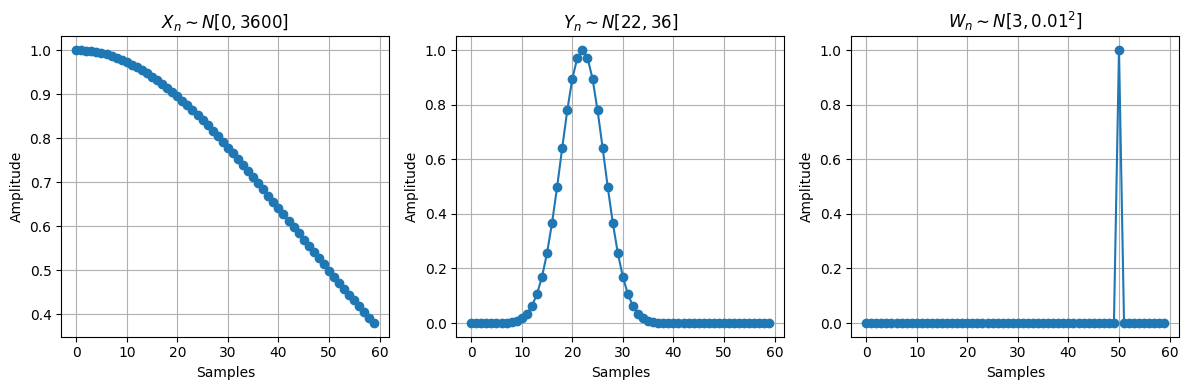

In [35]:
def GaussN(u: float, s: float, N: float) -> np.ndarray:
    n = np.arange(N)  
    gauss_signal = np.exp(-((n - u)**2) / ((s+1e-6)**2) )  #find unnormalized gaussian
    gauss_signal = gauss_signal/( np.max(gauss_signal)+1e-6) # normalizing 
    return gauss_signal

canonized_normal_dist = GaussN(0,60,60)
mean_shifted_high_variance = GaussN(22,6,60)
delta= GaussN(50,0.01,60)



hw1.plot_three_side_by_side(np.arange(60),canonized_normal_dist,np.arange(60),mean_shifted_high_variance,np.arange(60),delta,titles=[r"$X_n \sim N[0,3600]$",r"$Y_n \sim N[22,36]$"
                                                                                               ,r"$W_n \sim N[3,0.01^2]$"])

We can notice that really similar to Gauss in hw1 the examples maintain the expected characteristics, however their amplitude at the maximum is now 1. 

### New Composite Blocks (Blocks Built off of other blocks)

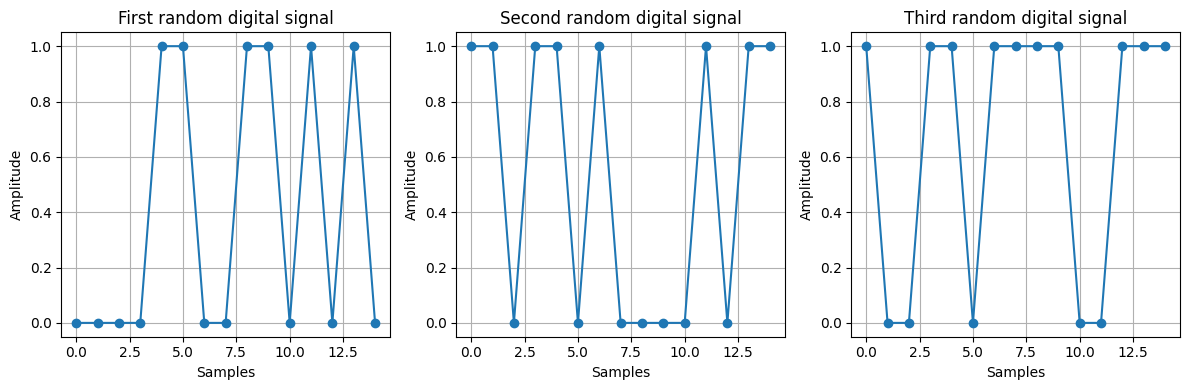

In [30]:
def DigitalRandom(N):
    x = BThresh(hw2.Rand(N),0.5)
    return x 

x,y,z = DigitalRandom(15),DigitalRandom(15),DigitalRandom(15)

hw1.plot_three_side_by_side(np.arange(15),x,np.arange(15),y,np.arange(15),z,titles = ["First random digital signal",
                                                                                                                                      "Second random digital signal",
                                                                                                                                      "Third random digital signal"])


#### DigitalRandom Explanation
- we notice how we created three vectors of length 15, we made a $\mathcal{U}[0,1]$ random vector and applied BThresh with a threshold of 1/2 to create them, <br/>
the vectors are random but approximately 1/2 of the time they are 1 and the other half zero since $P(\mathcal{U}[0,1]>\frac{1}{2}) = 0.5$


#### DigitalRandom Block Diagram 
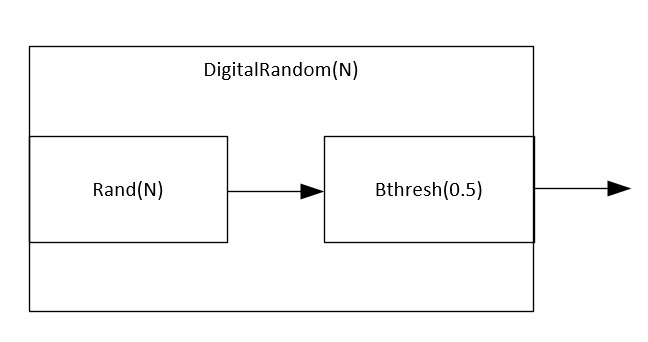


### Quantizer Helper Block

- quantizes a random scalar float from 0 to N to an integer level by repeatedly applying Bthresh with a rising threshold, we essentially get a floor function <br/>
- Used just to roll a random natural number


In [65]:
def Quantizer(x,N):
    if x ==0:
        return 0 
    for i in range(N+1):
        if BThresh(x,i) == 0:
            return i-1

## EXAMPLES

print(Quantizer(2.99, 7))
print(Quantizer(3.99, 4))
print(Quantizer(5.891263, 6))
            

2
3
5


### Quantizer Block Diagram 
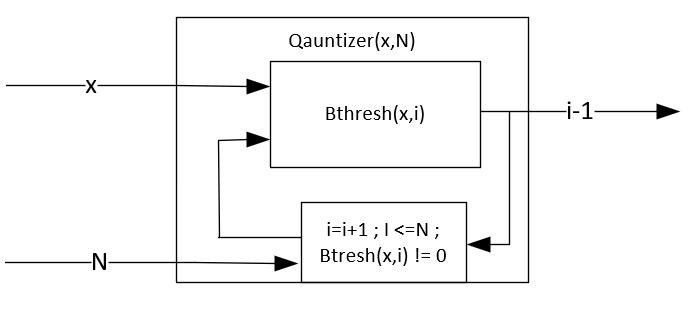

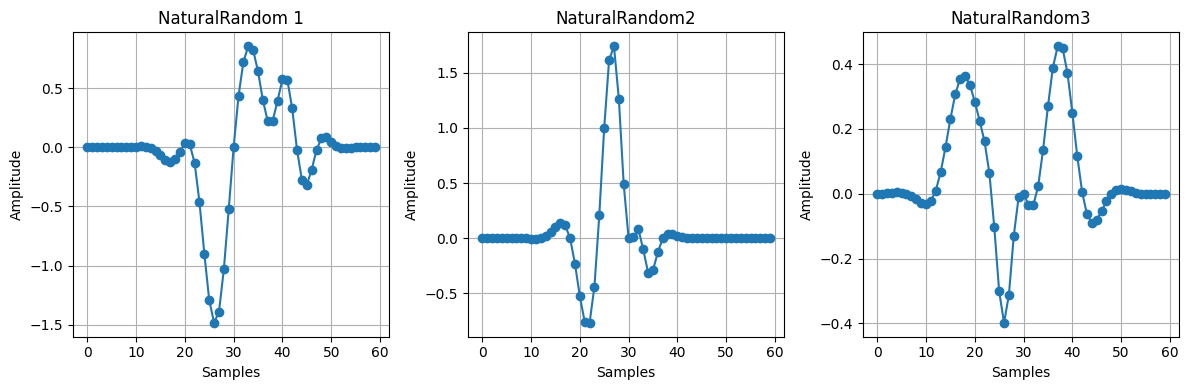

In [69]:
  
def NaturalRandom(N):
    x = np.zeros(N)
    for i in range(4):
        a_i = hw1.Scalar(hw1.Add(hw2.Rand(1),-0.5),4) 
        f_i = hw1.Add(1, Quantizer(hw1.Prod(hw2.Rand(1),7),8))
        mi = hw1.WGN(1,N/2,N/10)
        si = hw1.WGN(1,N/10,3)
        g_i = GaussN(mi,si,N)     
        x = hw1.Add(x,hw1.Prod(hw1.Scalar(hw1.Sine(f_i,N,0),a_i),g_i))
    return x

hw1.plot_three_side_by_side(np.arange(60),NaturalRandom(60),np.arange(60),NaturalRandom(60),np.arange(60),NaturalRandom(60),titles=["NaturalRandom 1",
                                                                                                                                    "NaturalRandom2",
                                                                                                                                    "NaturalRandom3"])


### NaturalRandom Explanation

We realize the formula that adds four localized sines multiplied by normalized gaussians  - the results exhibit sine-like behaviour localized in time, <br/>
we notice that the amplitudes are around between -2 and 2 which is as expected since those are the a_i coefficient ranges 

### NaturalRandom Block Diagram

- Generating $a_i \sim \mathcal{U}[-2,2]$ by shifting and scaling a uniform R.V 


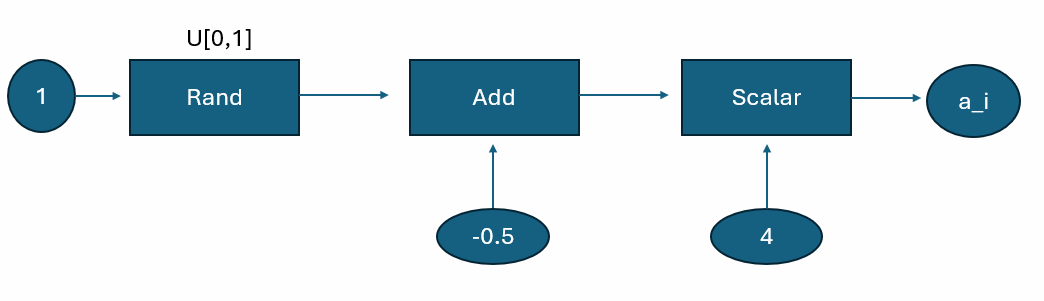

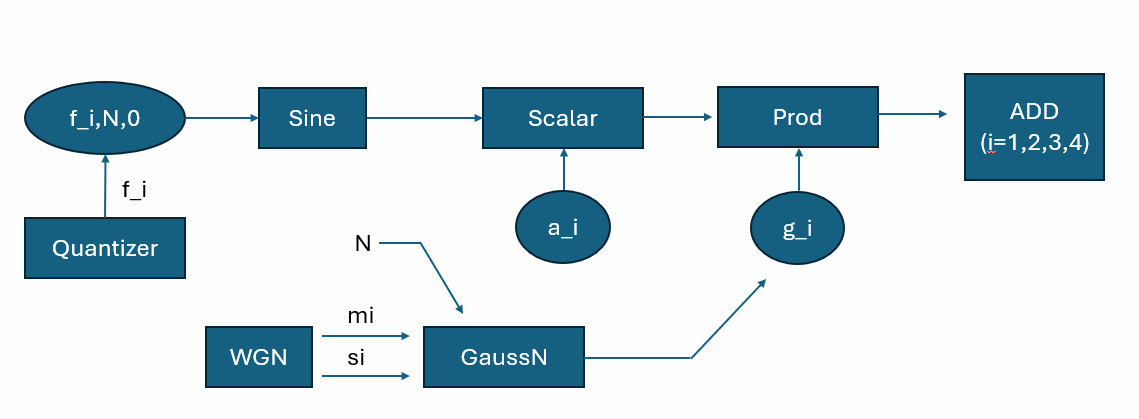

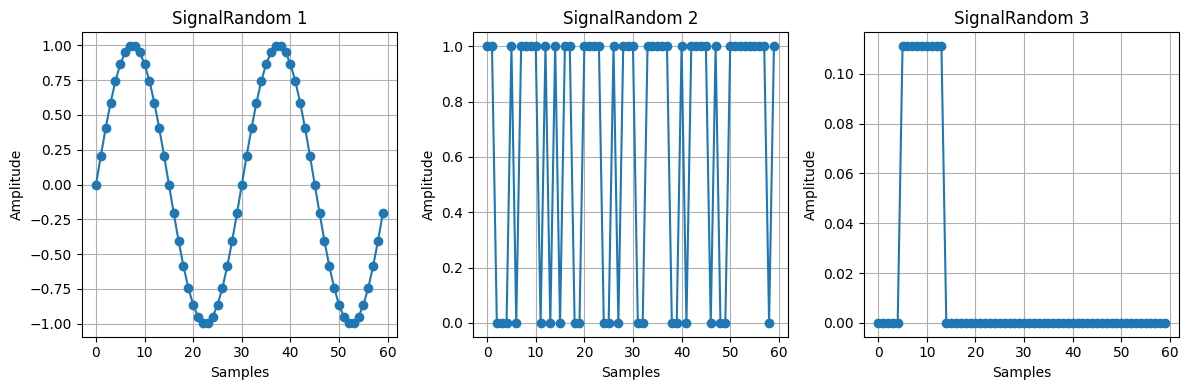

[0] [0] [1]


In [682]:
def MuxRandom(x,y):
    b = DigitalRandom(1)
    return hw1.Add(hw1.Prod(y,b),hw1.Prod(x,1-b)), b
#EXAMPLE 
# print(MuxRandom(1,2))
# print(MuxRandom(1,2))
# print(MuxRandom(1,2))
x,c = MuxRandom(hw1.Sine(2,60,0),hw1.Rect(5,14,60))
y,d = MuxRandom(DigitalRandom(60),hw1.WGN(60,0,1))
z,f = MuxRandom(hw1.WGN(60,0,1),hw1.Rect(5,14,60))
hw1.plot_three_side_by_side(np.arange(60),x,np.arange(60),y,np.arange(60),z,titles=["SignalRandom 1",
                                                                                                                                  "SignalRandom 2",
                                                                                                                                    "SignalRandom 3"])
print(c,d,f)



### Mux Random Explanation
Using the bernoulli RV we generate via SignalRandom(1) and 1-that bernoulli R.V we can have a set of complimentary binary random variables, <br/>
multiplying our signals by them creates the Random Mux. 


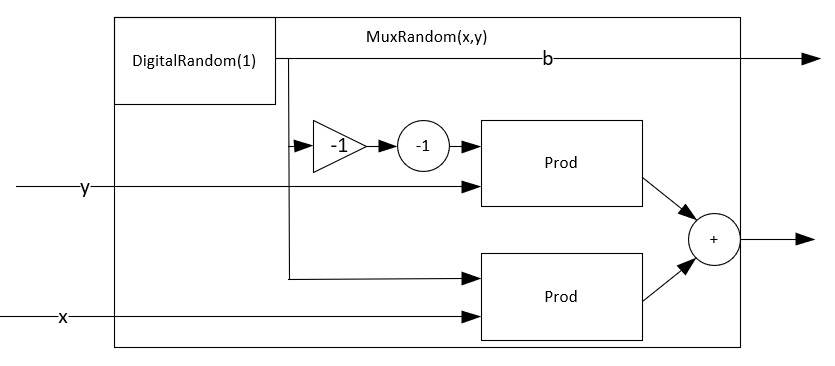

### SignalRandom

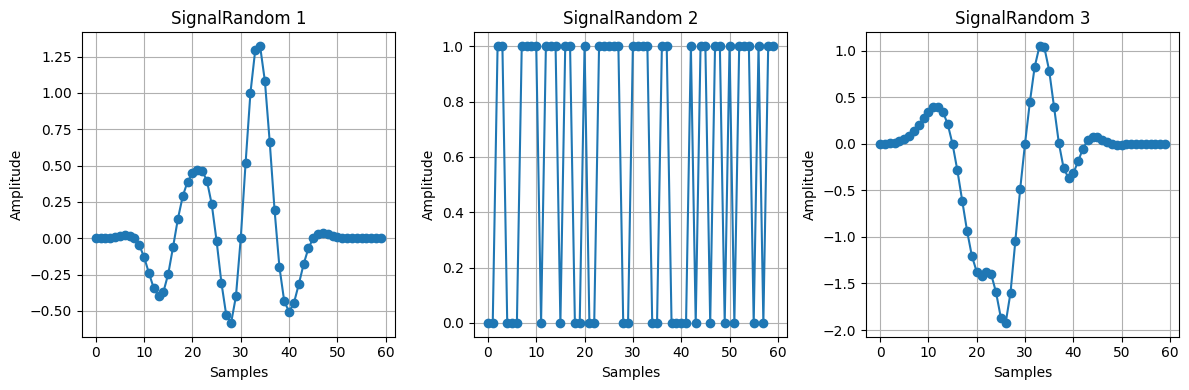

[1] [0] [1]


In [685]:
def SignalRandom(N): 
    return MuxRandom(DigitalRandom(N),NaturalRandom(N))
x, c= SignalRandom(60)
y,d = SignalRandom(60)
z,e = SignalRandom(60)
hw1.plot_three_side_by_side(np.arange(60),x,np.arange(60),y,np.arange(60),z,titles=["SignalRandom 1",
                                                                                                                                    "SignalRandom 2",
                                                                                                                                    "SignalRandom 3"])
print(c,d,e)


### SignalRandom Explanation
as expected, we generated at random either a digital signal or an analogue signal in either instance. <br/>
every slot upon re-running the program is either digial or analogue with probability 1/2 due to the signalMux block. <br/>
This is a private instance of the Mux Block

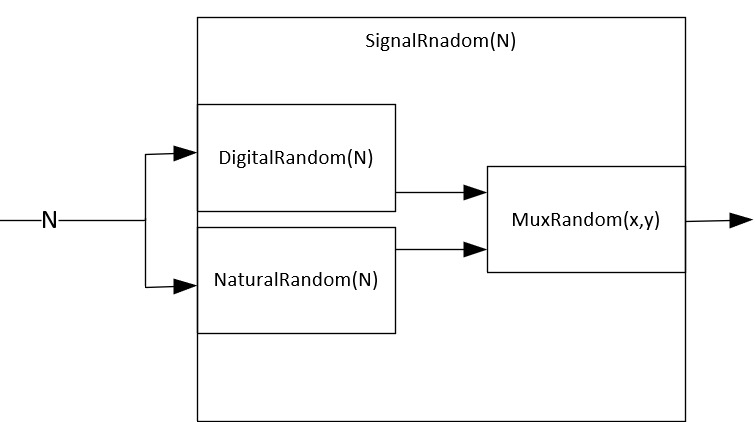

In [97]:
def GreaterThan(x,y):
    return hw1.Add(hw1.Prod(BThresh(x,y),x),hw1.Prod(BThresh(y,x),y))

### EXAMPLES
print(GreaterThan(5,6))
print(GreaterThan(-3,8.3285))
print(GreaterThan(0,-13))


[6]
[8.3285]
[0]


### GreaterThan Explanation
we can see how we get in the outputs the bigger numbers as expected, our method of achieveing that is with a use of ThreshB and Prod.
<br/>
ThreshB acts as a mask, such that only the greater number is multiplied by 1 (the one who isn't wiped out by the threshold), and the smaller number is zeroed out <br/>
we can see it works on whole, real and negative numbers

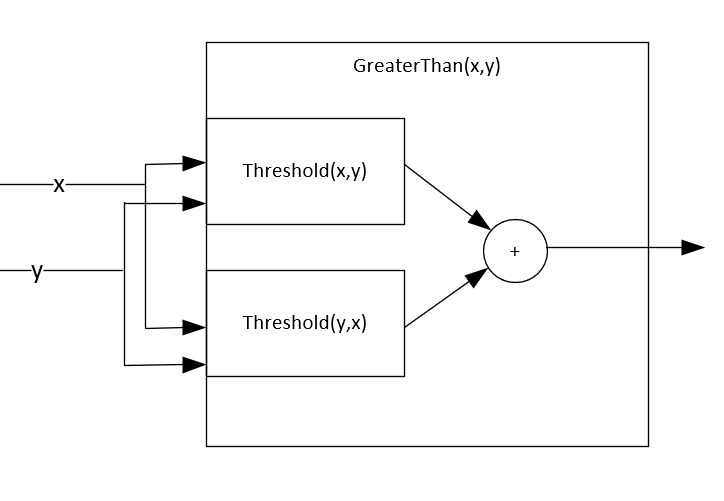

***
# Part 2 - Binary Classifier

### Helper Function: Absquared

In [320]:
def Absquared(z):
    return np.real(z*hw2.Conj(z)) #the real isn't necessary, it's just there to remove +0.00000000000j

print(Absquared([[3-1j,10-1j],[1j,0]]))
print(np.abs([[3-1j,1j],[1j,0]])**2)

[[ 10. 101.]
 [  1.   0.]]
[[10.  1.]
 [ 1.  0.]]


In [ ]:
def BinaryClassifier(x: np.ndarray): 
    print("fuckkkk")
    N=len(x) # assume 30
    sum_sig = hw1.Filter([1], hw1.Scalar(hw1.Rect(0,N, N),N),x)
    if not (GreaterThan(sum_sig, 0)):#the signal is Natural, really low values
        return 1
    if GreaterThan(sum_sig, 16) == sum_sig:
        return 0 #digital, high values 
    x_stft = Absquared(hw2.STFT(x,10))
    x_stft_rowsums=[]
    for i in range(10):  
        x_stft_rowsums.append(hw1.Filter([1], hw1.Scalar(hw1.Rect(0,3,3),3),x_stft[i])) #hw1.Rect(10-5+1,10,10),5
    high_freq = hw1.Filter([1],hw1.Scalar(hw1.Rect(0,5,10),5),x_stft_rowsums)
    freq_diff = hw1.Add(hw1.Filter([1],hw1.Scalar(hw1.Rect(0,10,10),10),x_stft_rowsums), hw1.Scalar(-2,high_freq))
    if GreaterThan(freq_diff,35)==freq_diff: #digital
        print("s")
        return 0
    else: 
        print("s")
        return 1
    
        
    
    
    
     
 # CODE FOR ANALYSIS   - to examine the different signal properties before deciding on an algorithm
    
# BinaryClassifier(DigitalRandom(30))
# x = DigitalRandom(30) + 0.5*hw1.WGN(30,0,1)
# y = NaturalRandom(30)+ 0.5*hw1.WGN(30,0,1)
# sum_x=0
# sum_y=0
# for i in range(1): 
#     x = DigitalRandom(30) + 0.5*hw1.WGN(30,0,1)
#     y = NaturalRandom(30)+ 0.5*hw1.WGN(30,0,1)
#     sum_x = sum_x + (np.sum(np.sum((Absquared(hw2.STFT(x,10))),axis=1)[:5]))-(np.sum(np.sum((Absquared(hw2.STFT(x,10))),axis=1)[5:])) #new thresh 35 
#     sum_y = sum_y + (np.sum(np.sum((Absquared(hw2.STFT(y,10))),axis=1)[:5]))-(np.sum(np.sum((Absquared(hw2.STFT(y,10))),axis=1)[5:]))  
# print("average diff digital = " ,sum_x/1)
# print("average diff analogue = " ,sum_y/1)
# print(np.sum((Absquared(hw2.STFT(x,10))),axis=1))

fuckkkk
s
average diff digital =  4.023502536484045
average diff analogue =  11.173806841760808
[36.995016 12.486902  7.734537  3.21562  14.808666 32.971514 14.808666
  3.21562   7.734537 12.486902]


### Explanation for Binary classifier

Using the code section commented out above we noticed the following: 
- the average of the analogue signals samples tends to be centered around zero, the sum of samples is small, and is sometimes negative, <br/>
whereas the digital signal is always nonzero- and is positive with every sample being a bernoulli RV with mean 1/2, this attribute carries over <br/>
largely when we add the noise since with mean zero it tends to cancel itself when adding up the samples. <br/> 
We leveraged that so that our first classification barrier is whether the sum is negative (natural) or large (binary). <br/>

- if we didn't get a definitive conclusion, we looked at the squared absolute values of the STFT - we noticed that if the difference between the high and low frequency components is greater than 35 that's indicative of the signal being digital, otherwise its more likely to be natural.

we realized this two-stage filtering function in blocks. 


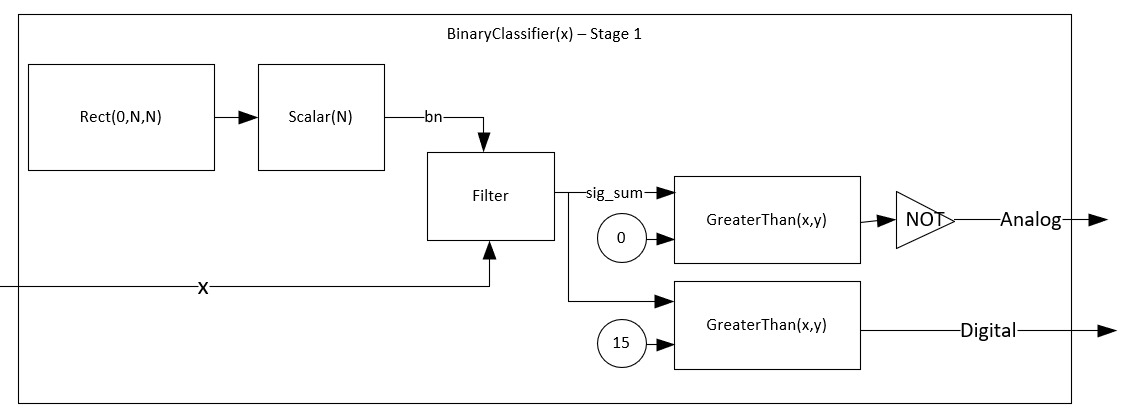

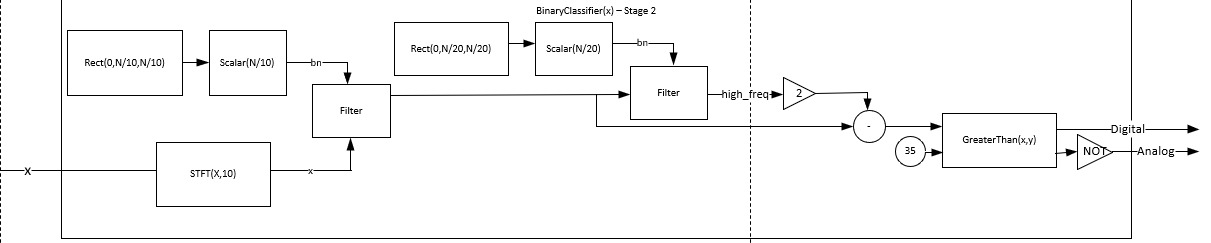

0


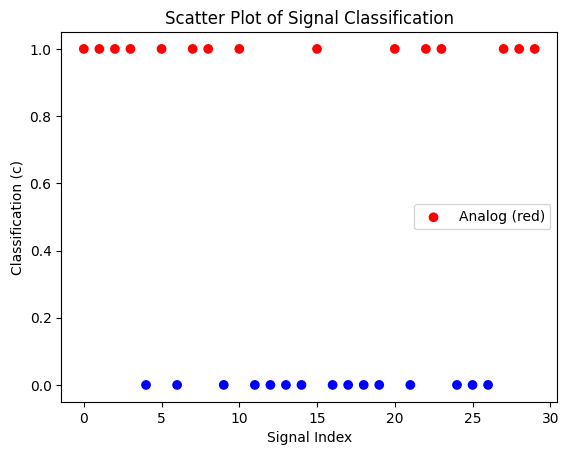

In [1171]:

labels = []
classification = []
for i in range(30):
    signal,label =SignalRandom(30)
    labels.append(label)
    if i <=9: 
        signal = hw1.Add(signal,hw1.Scalar(0.1,hw1.WGN(30,0,1)))
    elif i<=19 : 
        signal = hw1.Add(signal,hw1.Scalar(0.5,hw1.WGN(30,0,1)))
    classification.append(BinaryClassifier(signal))

diff=0
for i in range(30):
    diff = diff + sum(np.abs(labels[i]-classification[i]))
print(diff)

# Prepare data for scatter plot
x_values = np.arange(30)  # Index of signals
y_values = classification
# Create scatter plot
colors = ['blue' if label == 0 else 'red' for label in labels]

plt.scatter(x_values, y_values, c=colors, label="Classification Results")
plt.xlabel("Signal Index")
plt.ylabel("Classification (c)")
plt.title("Scatter Plot of Signal Classification")
plt.legend([ "Analog (red)","Digital (blue)"])
plt.show()